In [1]:
# Set working dir to project root",
import os
os.chdir('..')

In [120]:
%matplotlib inline

import pandas as pd
from glob import glob
import os
import numpy as np
import seaborn as sns
import urllib
import matplotlib as mpl

import matplotlib.pyplot as plt
from modules.ibu_utils import *

DF_EXPORT_DIR = "data/dataframes"

if not os.path.exists(DF_EXPORT_DIR):
    os.makedirs(DF_EXPORT_DIR)

TOP_SWEDES = [u'A. MAGNUSSON', u'E. NILSSON', u'M. PONSILUOMA', u'T. STENERSEN',
       u'L. PERSSON', u'J. NELIN', u'P. FEMLING', u'M. BRORSSON',
       u'S. SAMUELSSON', u'H. OEBERG']

In [121]:
def prepare_dataset(sex):
    index_dims = ["season", "event", "race", "sex", "name", "nat"]
    by_race_dims = ["season", "event", "sex", "race"]

    # Parse csv files for
    # ...ski time
    df_ski_time = get_ski_time(sex)[index_dims + ["ski_time"]]

    # ... time at range
    df_range_time = get_range_time(sex)[index_dims + ["range_time"]]

    # ... number of missed shots
    df_misses = get_misses(sex)[index_dims + ["misses"]]

    # ... the final (total) time
    df_final_time = get_final_time(sex)[index_dims + ["final_time_abs"]]

    
    # Merge all of the above
    df = df_ski_time.merge(df_range_time, on=index_dims, how="outer")\
                    .merge(df_misses, on=index_dims, how="outer")\
                    .merge(df_final_time, on=index_dims, how="outer")


        # For race dates
    calendar_path = os.path.join(DATA_DIR, "2018-2019_race_calendar.csv")
    calendar_df = pd.read_csv(calendar_path, encoding="utf-8")[["event", "race", "date"]]
    df = df.merge(calendar_df, on=["event", "race"], how="left")

    df["runner"] = df["name"] + " (" + df["nat"] + ")" # H. OEBERG (swe), assuming uniquness of name + nationality
    
    # Create a str unique for the race to make group bys more convenient later
    df["race_key"] = df[["season", "event", "race"]].apply(lambda x: ", ".join(x.tolist()), axis=1)
    df["discipline"] = df["race"].str.split("km ").str[-1] # "Sprint", "Mass Start" etc
    df["discipline"] = df["discipline"].replace({"Short Individual": "Individual"})

    df["n_shootings"] = 4
    df.loc[df["discipline"] == "Sprint", "n_shootings"] = 2
    df["n_shots"] = df["n_shootings"] * 5
    df["shot_pct"] = 1 - (df["misses"] / df["n_shots"])
    
    df["penalty_time"] = df["final_time_abs"] - df["ski_time"] - df["range_time"]
    df["ski_and_range_time"] = df["ski_time"] + df["range_time"]

    # Hackish: "Penalty time" will always include the time it takes to ski between the shooting range
    # and the penalty lap. So even runners with no penalites will have a little bit of penalty time.
    # When we compute the hypothetical time (without penalites) we need to add this time.
    # It is roughly 5-6 seconds, and we compute it across the whole season. We don't, in other words,
    # take into account the potential difference between different courses.
    range_to_penalty_time = df[df["misses"]==0]["penalty_time"] / df["n_shootings"] 
    range_to_penalty_time_median = range_to_penalty_time.median()
    
    # Penalty time without range to penalty
    penalty_time_without_transport = (df["penalty_time"] - range_to_penalty_time_median * df["n_shootings"]).dt.total_seconds()
    penalty_time_without_transport[penalty_time_without_transport < 0] = 0
    # Get the average time of each penalty round
    df["avg_penalty_time"] = penalty_time_without_transport / df["misses"]
    df["avg_penalty_time"] = df["avg_penalty_time"].replace([np.inf, -np.inf], np.nan)
    
    has_clean_shooting = df["misses"] == 0
    # For runners with no penalties the final time without penalties will be same as the actual final time
    df.loc[has_clean_shooting, "final_time_without_penalty"] = df["final_time_abs"]
    # ...for others we subtract the penalty time and add the time from range to penalty lap
    df.loc[~has_clean_shooting, "final_time_without_penalty"] = df["final_time_abs"] - df["penalty_time"] + range_to_penalty_time_median * df["n_shootings"]
    
    # Compute total rank in race
    df["rank"] = df.groupby(by_race_dims)["final_time_abs"].rank()
    df["is_top_30"] = df["rank"] <= 30
    df["is_top_10"] = df["rank"] <= 10
    df["is_top_5"] = df["rank"] <= 5
    df["is_top_3"] = df["rank"] <= 3
    df["is_winner"] = df["rank"] == 1

    # Avg rank for runner in all races
    df["mean_rank"] = df.groupby("runner")["rank"].transform(lambda x: x.mean())
    df["median_rank"] = df.groupby("runner")["rank"].transform(lambda x: x.median())
    
    # Ski speed rank
    df["ski_rank"] = df.groupby(by_race_dims)["ski_time"].rank()
    df["mean_ski_rank"] = df.groupby("runner")["ski_rank"].transform(lambda x: x.mean())
    df["median_ski_rank"] = df.groupby("runner")["ski_rank"].transform(lambda x: x.median())
    
    # Compute the diff between the winning time and the runners time.
    def compute_winner_diff(_df):
        best_time = _df["final_time_abs"].sort_values().iloc[0]
        podium_time = _df["final_time_abs"].sort_values().iloc[2] # third best time 
        _df["winner_time"] = best_time
        _df["podium_time"] = podium_time
        _df["winner_diff"] = _df["final_time_abs"] - best_time
        _df["podium_diff"] = _df["final_time_abs"] - podium_time
        _df["winner_diff_without_pen"] = _df["final_time_without_penalty"] - best_time
        _df["podium_diff_without_pen"] = _df["final_time_without_penalty"] - podium_time
        _df["could_have_won"] = best_time > _df["final_time_without_penalty"]
        _df["could_have_podium"] = podium_time > _df["final_time_without_penalty"]
        return _df
    
    df = df.groupby(by_race_dims).apply(compute_winner_diff)    
    
    # Does the runner rank top 30 on average?
    df["is_top_runner"] = df.groupby(["season", "runner"])["rank"].transform(lambda x: x.mean() < 30)

    def vs_top_30(x):
        """Calculate how much:
        a) the runner differs from mean of the top 30 runners
        b) how many standard deviation differs from the mean
        """
        x[col + "_vs_mean"] = x[col] -  x.loc[x["is_top_30"], col].mean()
        try:
            x[col + "_vs_mean_pct"] = x[col] /  x.loc[x["is_top_30"], col].mean() - 1
        except TypeError:
            # don't crash if all missing
            x[col + "_vs_mean_pct"] = np.NaN
        try:
            x[col + "_vs_mean_std"] = x[col + "_vs_mean"] / x.loc[x["is_top_30"], col + "_vs_mean"].std()
        except TypeError:
            # don't crash if all missing
            x[col + "_vs_mean_std"] = np.NaN
        
        # Hackish: nullify some apparent errors in data
        #is_outlier = x[col + "_vs_mean_std"].abs() > 10
        #x.loc[is_outlier, col + "_vs_mean"] = np.NaN
        #x.loc[is_outlier, col + "_vs_mean_std"] = np.NaN
        #x.loc[is_outlier, col + "_vs_mean_pct"] = np.NaN

        return x

    for col in ["ski_time", "range_time", "penalty_time", "ski_and_range_time", "final_time_abs", "misses"]:
        df = df.groupby(by_race_dims).apply(vs_top_30)
    return df

df_women = prepare_dataset("Women")
df_men = prepare_dataset("Men")
df = pd.concat([df_women, df_men])

# Remove some apparent outliers
std_cols = [x for x in df.columns if "_std" in x]

has_outlier = df[df[std_cols].abs() > 15].count(axis=1) > 0
df = df[~has_outlier]


file_path = os.path.join(DF_EXPORT_DIR, "by_race_and_runner - prepared.csv")
df.to_csv(file_path, encoding="utf-8")
print "Save data frame to {}".format(file_path)

df = df[df["discipline"] != "Pursuit"]
df = df.reset_index().drop(columns="index")
df = df.drop_duplicates()
df.head()

/home/jens/.local/lib/python2.7/site-packages/ipykernel_launcher.py:53: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.


Save data frame to data/dataframes/by_race_and_runner - prepared.csv


season           event                    race    sex           name  \
0  2018-2019  Pokljuka (SLO)  Women 15 km Individual  women  K. INNERHOFER   
1  2018-2019  Pokljuka (SLO)  Women 15 km Individual  women     S. DUNKLEE   
2  2018-2019  Pokljuka (SLO)  Women 15 km Individual  women      D. WIERER   
3  2018-2019  Pokljuka (SLO)  Women 15 km Individual  women     L. PERSSON   
4  2018-2019  Pokljuka (SLO)  Women 15 km Individual  women       J. SIMON   

   nat        ski_time      range_time  misses  final_time_abs  \
0  aut 00:39:05.700000 00:03:15.300000     4.0 00:46:47.100000   
1  usa 00:39:28.900000 00:03:12.500000     1.0 00:44:07.500000   
2  ita 00:38:30.900000 00:02:43.900000     2.0        00:43:40   
3  swe 00:39:38.900000 00:03:31.200000     1.0 00:44:35.800000   
4  fra 00:39:18.200000 00:02:43.900000     3.0 00:45:27.800000   

          ...         penalty_time_vs_mean_std ski_and_range_time_vs_mean  \
0         ...                         2.484274   -1 days +23:59:53.933333   
1         ...                        -0.415594            00:00:14.333333   
2         ...                         0.536529   -1 days +23:58:47.733333   
3         ...                        -0.422038            00:00:43.033333   
4         ...                         1.511207   -1 days +23:59:35.033333   

  ski_and_range_time_vs_mean_pct ski_and_range_time_vs_mean_std  \
0                      -0.002382                      -0.121649   
1                       0.005627                       0.287413   
2                      -0.028373                      -1.449096   
3                       0.016895                       0.862907   
4                      -0.009802                      -0.500633   

    final_time_abs_vs_mean  final_time_abs_vs_mean_pct  \
0          00:02:28.136666                    0.055712   
1 -1 days +23:59:48.536666                   -0.004311   
2 -1 days +23:59:21.036666                   -0.014654   
3          00:00:16.836666                    0.006332   
4          00:01:08.836666                    0.025889   

   final_time_abs_vs_mean_std misses_vs_mean misses_vs_mean_pct  \
0                    3.819757       2.566667           1.790698   
1                   -0.295586      -0.433333          -0.302326   
2                   -1.004683       0.566667           0.395349   
3                    0.434139      -0.433333          -0.302326   
4                    1.774978       1.566667           1.093023   

   misses_vs_mean_std  
0            2.467938  
1           -0.416665  
2            0.544869  
3           -0.416665  
4            1.506404  

[5 rows x 59 columns]

In [289]:

df.

ski_time_vs_mean_std  range_time_vs_mean_std  penalty_time_vs_mean_std  \
81                1.200010               -0.201670                  3.455729   
127              -0.268321               -0.149398                  1.830046   
237              -0.614509               -0.615523                 -0.025993   
341              -0.845700                0.275426                 -0.048717   
406              -0.388198               -0.496886                 -1.025537   
504              -0.608941               -0.961728                  0.376977   
631              -0.123943               -0.193564                 -0.050958   
926              -0.756401               -0.574478                  2.114833   
962               0.286479               -0.193605                  3.450429   
1043              0.421074               -0.465909                  1.488275   
1156             -0.431531                1.082470                 -0.069767   

      ski_and_range_time_vs_mean_std  final_time_abs_vs_mean_std  \
81                          1.155667                    7.017141   
127                        -0.309508                    1.292620   
237                        -0.836749                   -0.760008   
341                        -0.739586                   -0.816469   
406                        -0.548826                   -1.133892   
504                        -0.861188                   -0.444483   
631                        -0.181858                   -0.243050   
926                        -0.882177                    0.424777   
962                         0.246087                    2.097879   
1043                        0.215134                    1.391957   
1156                       -0.121759                   -0.135366   

      misses_vs_mean_std  
81              3.429473  
127             1.817870  
237            -0.025652  
341             0.019883  
406            -1.002230  
504            -0.128001  
631            -0.073487  
926             1.704467  
962             3.311439  
1043            1.346291  
1156            0.000000

## Overview

In [37]:
df.groupby(["event", "sex"]).size()

event                       sex  
Antholz-Anterselva (ITA)    men      138
                            women    141
Canmore (CAN)               men       98
                            women     93
Hochfilzen (AUT)            men      110
                            women    116
Nove Mesto (CZE)            men      137
                            women    155
Oberhof (GER)               men      108
                            women    115
Pokljuka (SLO)              men      221
                            women    207
Ruhpolding (GER)            men      141
                            women    148
Soldier Hollow, Utah (USA)  men       87
                            women     86
dtype: int64

In [38]:
df.iloc[0]

season                                                                    2018-2019
event                                                                Pokljuka (SLO)
race                                                         Women 15 km Individual
sex                                                                           women
name                                                                  K. INNERHOFER
nat                                                                             aut
ski_time                                                     0 days 00:39:05.700000
range_time                                                   0 days 00:03:15.300000
misses                                                                            4
final_time_abs                                               0 days 00:46:47.100000
date                                                                     2018-12-06
runner                                                          K. INNERHOFE

## Which races could X have won?

Chart url: https://www.dropbox.com/s/e6yw0wtposgc96i/vilka+lopp+hade+Anna+Magnusson+kunnat+vinna.svg?dl=0


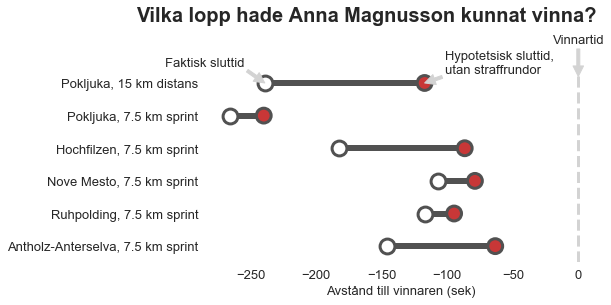

Chart url: https://www.dropbox.com/s/e6yw0wtposgc96i/vilka+lopp+hade+Emma+Nilsson+kunnat+vinna.svg?dl=0


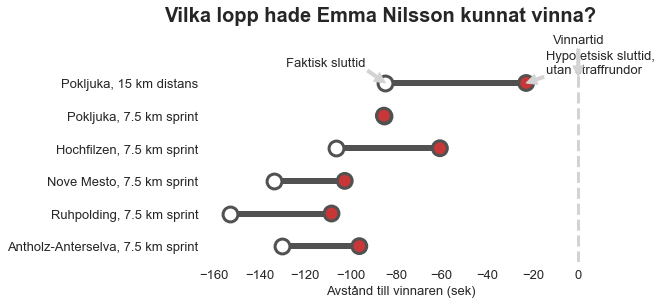

Chart url: https://www.dropbox.com/s/e6yw0wtposgc96i/vilka+lopp+hade+Martin+Ponsiluoma+kunnat+vinna.svg?dl=0


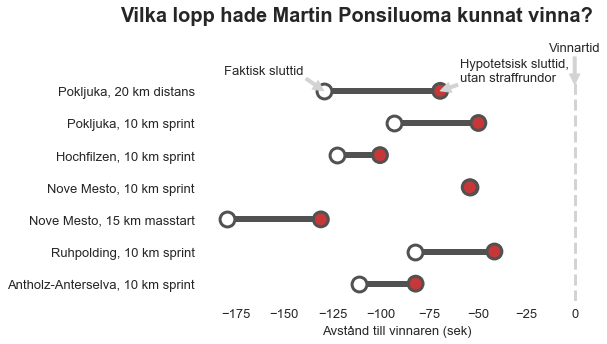

Chart url: https://www.dropbox.com/s/e6yw0wtposgc96i/vilka+lopp+hade+Torstein+Stenersen+kunnat+vinna.svg?dl=0


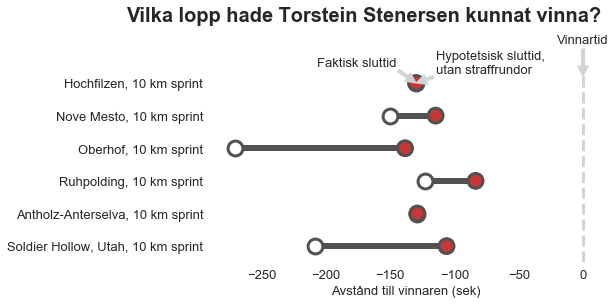

Chart url: https://www.dropbox.com/s/e6yw0wtposgc96i/vilka+lopp+hade+Linn+Persson+kunnat+vinna.svg?dl=0


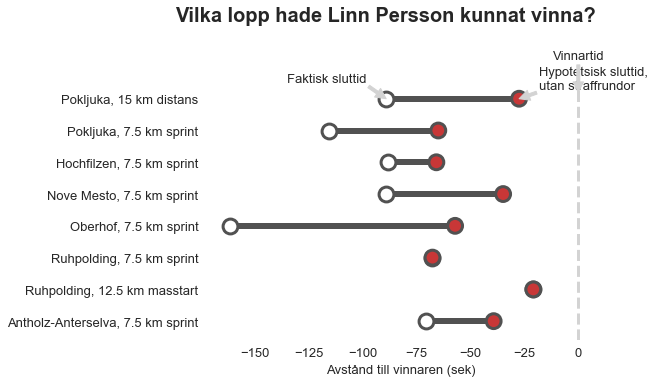

Chart url: https://www.dropbox.com/s/e6yw0wtposgc96i/vilka+lopp+hade+Jesper+Nelin+kunnat+vinna.svg?dl=0


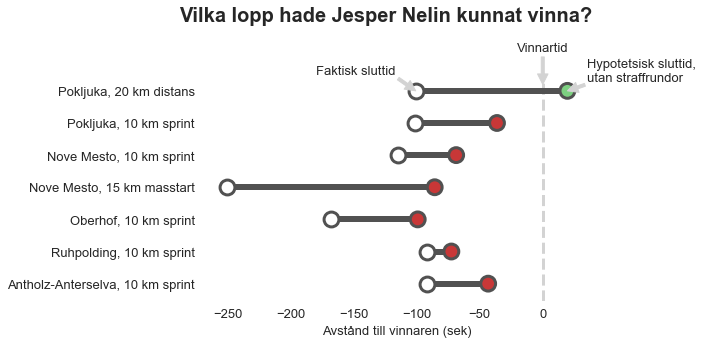

Chart url: https://www.dropbox.com/s/e6yw0wtposgc96i/vilka+lopp+hade+Peppe+Femling+kunnat+vinna.svg?dl=0


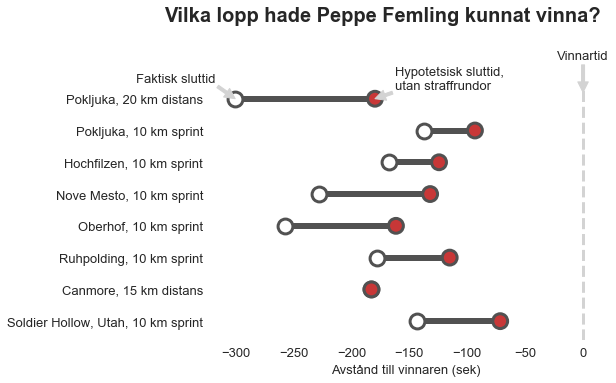

Chart url: https://www.dropbox.com/s/e6yw0wtposgc96i/vilka+lopp+hade+Mona+Brorsson+kunnat+vinna.svg?dl=0


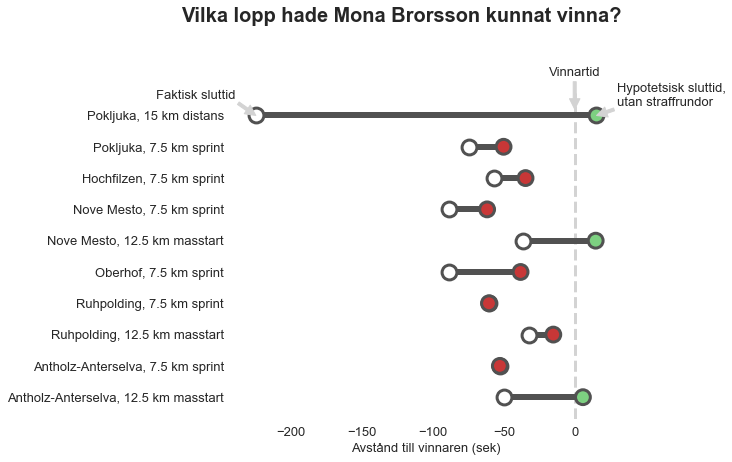

Chart url: https://www.dropbox.com/s/e6yw0wtposgc96i/vilka+lopp+hade+Sebastian+Samuelsson+kunnat+vinna.svg?dl=0


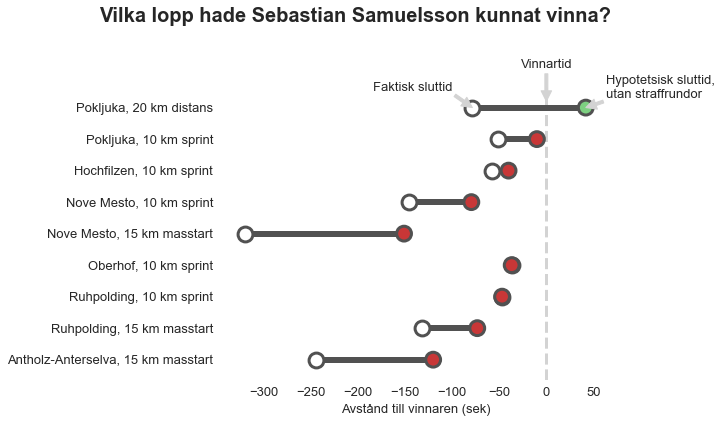

Chart url: https://www.dropbox.com/s/e6yw0wtposgc96i/vilka+lopp+hade+Hanna+%C3%96berg+kunnat+vinna.svg?dl=0


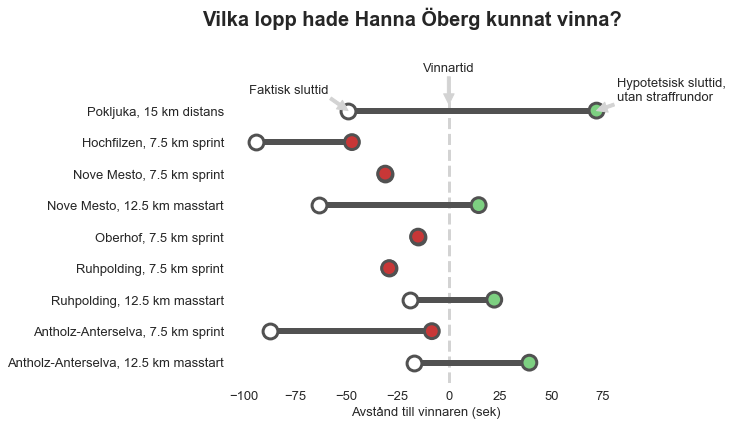

In [15]:


#RUNNER = "K. MAKARAINEN (fin)"
def range_plot(filter_col, filter_value, title, compare_with="winner"):
    assert compare_with in ["winner", "podium"]
    df_viz = df[(df[filter_col] == filter_value) & df["{}_diff".format(compare_with)].notna()]
    
    if filter_col == "nat":
        df_viz = df_viz.sort_values(["sex", "mean_rank", "date"], ascending=False)
    elif filter_col == "race_key":
        df_viz = df_viz.sort_values(["rank"], ascending=False)

    elif filter_col in ["name", "runner"]:
        df_viz = df_viz.sort_values(["date"], ascending=False)
        

    x0 = -df_viz["{}_diff".format(compare_with)].dt.total_seconds()
    x1 = -df_viz["{}_diff_without_pen".format(compare_with)].dt.total_seconds()

    sns.set_style("white")
    fig, ax = plt.subplots(figsize=(7, df_viz.shape[0] * 0.6))


    my_range=range(1,len(df_viz.index)+1)
    COLOR_GREEN = "#7dd081"
    COLOR_GRAY = "#515151"
    COLOR_RED = "#c83737"
    STROKE_WIDTH = 3
    stroke_color = COLOR_GRAY
    DOT_SIZE=220
    colors = [ COLOR_RED if x < 0 else COLOR_GREEN for x in x1]

    ax.axvline(0, c="lightgray", ls="dashed", zorder=0,linewidth=STROKE_WIDTH)
    plt.hlines(y=my_range, xmin=x0, xmax=x1, color=stroke_color, lw=STROKE_WIDTH * 2, zorder=1)
    plt.scatter(x0, my_range, color="white", edgecolor=stroke_color, linewidth=STROKE_WIDTH, label='Faktisk sluttid', s=DOT_SIZE, zorder=2)

    plt.scatter(x1, my_range, color=colors, edgecolor=stroke_color, linewidth=STROKE_WIDTH, label=u'Förvänta sluttid', s=DOT_SIZE, zorder=3)

    sns.despine(left=True, bottom=True)
    
    if filter_col == "nat":
        plt.yticks(my_range, df_viz["name"] + " (" + df_viz["date"] + ")")
    elif filter_col == "race_key":
        plt.yticks(my_range, df_viz["runner"])
    elif filter_col in ["name", "runner"]:
        labels = df_viz['race_key'].apply(t)
        plt.yticks(my_range, labels)#df_viz['event'] + ", " + df_viz['race'].str.replace("Women", ""))

    fp_x0, fp_x1 = x0.iloc[-1], x1.iloc[-1]
    fp_y = my_range[-1]

    arrowprops = dict(color='lightgray',
                                headlength=STROKE_WIDTH * 3.5,
                                headwidth=STROKE_WIDTH * 3.5,
                               width=STROKE_WIDTH)

    ax.annotate(u'Faktisk sluttid',
                xy=(fp_x0, fp_y),
                xytext=(-20, 20), textcoords='offset pixels',
                horizontalalignment='right',
                verticalalignment='center',
                arrowprops=arrowprops)

    ax.annotate(u'Hypotetsisk sluttid,\nutan straffrundor',
                xy=(fp_x1, fp_y),
                xytext=(20, 20), textcoords='offset pixels',
                horizontalalignment='left',
                verticalalignment='center',
                arrowprops=arrowprops)

    if compare_with == "winner":
        compare_label = u"Vinnartid"
    elif compare_with == "podium":
        compare_label = u"Bronstid"
    
    ax.annotate(compare_label,
                xy=(0, my_range[-1]+.2),
                xytext=(0, 30), textcoords='offset pixels',
                horizontalalignment='center',
                verticalalignment='bottom',
                arrowprops=arrowprops)

    if compare_with == "winner":
        xlabel = u"Avstånd till vinnaren (sek)"
    elif compare_with == "podium":
        xlabel = u"Avstånd till pallen (sek)"
    ax.set_xlabel(xlabel)
    ax.set_title(title.format(t(filter_value)[:20]), y=1.2, loc='right')

    #plt.legend(loc="lower right")
    
    if compare_with == "winner":
        file_name = u"vilka lopp hade {} kunnat vinna".format(t(filter_value))
    elif compare_with == "podium":
        file_name = u"i vilka lopp hade {} kunnat vara på pallen?".format(t(filter_value))

    #box = ax.get_position()
    #ax.set_position([box.x0, box.y0 + box.height * 0.1,box.width, box.height * 0.9])

    # Put a legend below current axis
    #ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)
    
        
    save_chart(file_name, plt)
    #fig.tight_layout()
    plt.show()
    return plt

COMPARE_WITH = "winner"
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 13
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.titleweight'] = 'bold'
mpl.rcParams['axes.titlesize'] = 20


for runner_name in TOP_SWEDES:    
    if COMPARE_WITH == "winner":
        chart_title = u"Vilka lopp hade {} kunnat vinna?"
    elif COMPARE_WITH == "podium":
        chart_title = u"I vilka lopp hade {} kunnat vara på pallen?"
    range_plot("name", runner_name, chart_title, compare_with=COMPARE_WITH)

#range_plot("nat", "ita", u"Vilka lopp hade {} kunnat vinna?")
#range_plot("race_key", "2018-2019, Ruhpolding (GER), Women 12.5 km Mass Start", "Vem hade kunnat vinna {}")



#range_plot("name", "H. OEBERG", u"I vilka lopp hade {} kunnat vara på pallen?", compare_with=COMPARE_WITH)

In [55]:


import matplotlib.font_manager
matplotlib.font_manager._rebuild()



In [56]:
df.race_key.unique()

array(['2018-2019, Pokljuka (SLO), Women 15 km Individual',
       '2018-2019, Pokljuka (SLO), Women 7.5 km Sprint',
       '2018-2019, Canmore (CAN), Women 12.5 km Short Individual',
       '2018-2019, Ruhpolding (GER), Women 12.5 km Mass Start',
       '2018-2019, Ruhpolding (GER), Women 7.5 km Sprint',
       '2018-2019, Oberhof (GER), Women 7.5 km Sprint',
       '2018-2019, Antholz-Anterselva (ITA), Women 7.5 km Sprint',
       '2018-2019, Nove Mesto (CZE), Women 7.5 km Sprint',
       '2018-2019, Nove Mesto (CZE), Women 12.5 km Mass Start',
       '2018-2019, Soldier Hollow, Utah (USA), Women 7.5 km Sprint',
       '2018-2019, Hochfilzen (AUT), Women 7.5 km Sprint',
       '2018-2019, Antholz-Anterselva (ITA), Women 12.5 km Mass Start',
       '2018-2019, Oberhof (GER), Men 10 km Sprint',
       '2018-2019, Pokljuka (SLO), Men 10 km Sprint',
       '2018-2019, Pokljuka (SLO), Men 20 km Individual',
       '2018-2019, Ruhpolding (GER), Men 10 km Sprint',
       '2018-2019, Soldier

In [47]:
# Vilka svenskar hade kunnat vinna VC-loppen i år?
df_sweden = df[df["nat"] == "swe"]
df_sweden[df["could_have_won"]].groupby(["sex", "name", "discipline"]).size()

/home/jens/.local/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


sex    name           discipline
men    J. NELIN       Individual    1
       S. SAMUELSSON  Individual    1
women  H. OEBERG      Individual    1
                      Mass Start    3
       M. BRORSSON    Individual    1
                      Mass Start    2
dtype: int64

/home/jens/.local/lib/python2.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Chart url: https://www.dropbox.com/s/e6yw0wtposgc96i/antal+%C3%A5kare+med+vinstchans.svg?dl=0
Table url: https://www.dropbox.com/s/e6yw0wtposgc96i/antal+%C3%A5kare+med+vinstchans.xlsx?dl=0


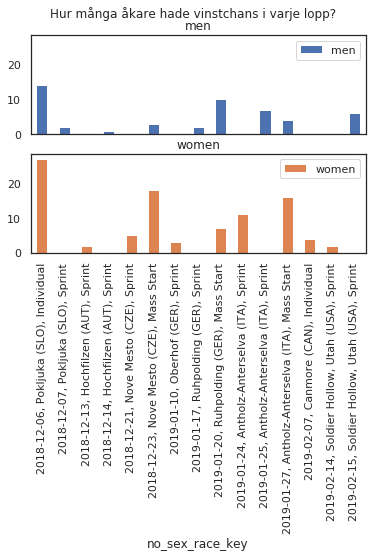

In [334]:


    
    
table_df = df[df["could_have_won"]]

table_df["no_sex_race_key"] = table_df["date"] + ", " + table_df["event"] + ", " + table_df["discipline"]

table_df = table_df.groupby(["sex", "no_sex_race_key"]).size()
ax = table_df.unstack(0).plot(kind='bar', subplots=True, sharey=True)
plt.suptitle(u"Hur många åkare hade vinstchans i varje lopp?")
save_chart(u"antal åkare med vinstchans", g)
save_table(u"antal åkare med vinstchans", table_df)
plt.show()

In [336]:
print(u"Hur mång åkare, sammanlagt, har haft hypotetisk vinstchans?")
df[df["could_have_won"]].groupby("sex")["name"].nunique()

Hur mång åkare, sammanlagt, har haft hypotetisk vinstchans?


sex
men      23
women    35
Name: name, dtype: int64

## Who are the top skiers?

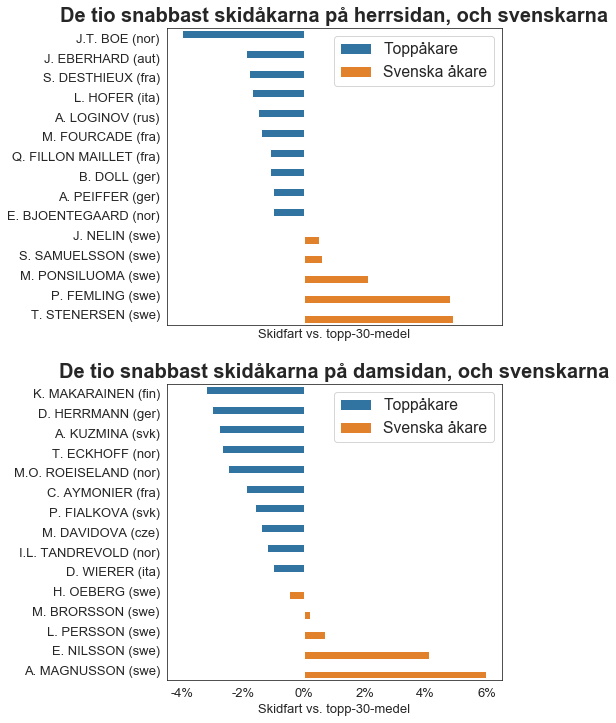

Table url: https://www.dropbox.com/s/e6yw0wtposgc96i/snabbaste+skid%C3%A5karna.xlsx?dl=0


Rank  \
sex   runner                          
men   J.T. BOE (nor)            1.0   
      J. EBERHARD (aut)         2.0   
      S. DESTHIEUX (fra)        3.0   
      L. HOFER (ita)            4.0   
      A. LOGINOV (rus)          5.0   
      M. FOURCADE (fra)         6.0   
      Q. FILLON MAILLET (fra)   7.0   
      B. DOLL (ger)             8.0   
      A. PEIFFER (ger)          9.0   
      E. BJOENTEGAARD (nor)    10.0   
      J. NELIN (swe)           23.0   
      S. SAMUELSSON (swe)      25.0   
      M. PONSILUOMA (swe)      45.0   
      P. FEMLING (swe)         82.0   
      T. STENERSEN (swe)       83.0   
women K. MAKARAINEN (fin)       1.0   
      D. HERRMANN (ger)         2.0   
      A. KUZMINA (svk)          3.0   
      T. ECKHOFF (nor)          4.0   
      M.O. ROEISELAND (nor)     5.0   
      C. AYMONIER (fra)         6.0   
      P. FIALKOVA (svk)         7.0   
      M. DAVIDOVA (cze)         8.0   
      I.L. TANDREVOLD (nor)     9.0   
      D. WIERER (ita)          10.0   
      H. OEBERG (swe)          18.0   
      M. BRORSSON (swe)        23.0   
      L. PERSSON (swe)         28.0   
      E. NILSSON (swe)         65.0   
      A. MAGNUSSON (swe)       77.0   

                               Procent snabbare/långsammare än topp-30-snitt  \
sex   runner                                                                   
men   J.T. BOE (nor)                                                    -4.0   
      J. EBERHARD (aut)                                                 -1.9   
      S. DESTHIEUX (fra)                                                -1.8   
      L. HOFER (ita)                                                    -1.7   
      A. LOGINOV (rus)                                                  -1.5   
      M. FOURCADE (fra)                                                 -1.4   
      Q. FILLON MAILLET (fra)                                           -1.1   
      B. DOLL (ger)                                                     -1.1   
      A. PEIFFER (ger)                                                  -1.0   
      E. BJOENTEGAARD (nor)                                             -1.0   
      J. NELIN (swe)                                                     0.5   
      S. SAMUELSSON (swe)                                                0.6   
      M. PONSILUOMA (swe)                                                2.1   
      P. FEMLING (swe)                                                   4.8   
      T. STENERSEN (swe)                                                 4.9   
women K. MAKARAINEN (fin)                                               -3.2   
      D. HERRMANN (ger)                                                 -3.0   
      A. KUZMINA (svk)                                                  -2.8   
      T. ECKHOFF (nor)                                                  -2.7   
      M.O. ROEISELAND (nor)                                             -2.5   
      C. AYMONIER (fra)                                                 -1.9   
      P. FIALKOVA (svk)                                                 -1.6   
      M. DAVIDOVA (cze)                                                 -1.4   
      I.L. TANDREVOLD (nor)                                             -1.2   
      D. WIERER (ita)                                                   -1.0   
      H. OEBERG (swe)                                                   -0.5   
      M. BRORSSON (swe)                                                  0.2   
      L. PERSSON (swe)                                                   0.7   
      E. NILSSON (swe)                                                   4.1   
      A. MAGNUSSON (swe)                                                 6.0   

                               Antal lopp  
sex   runner                               
men   J.T. BOE (nor)                   12  
      J. EBERHARD (aut)                12  
      S. DESTHIEUX (fra)               12  
 

In [22]:
by_runner = df.groupby(["sex", "runner"])
df_skiers = pd.concat([
  by_runner["ski_time_vs_mean_pct"].mean().rename("ski_time_vs_mean") * 100,
  by_runner["ski_time_vs_mean_pct"].count().rename("n_races"),
  by_runner["nat"].first(),
    
], axis=1)\
.sort_values(["sex" ,"ski_time_vs_mean"])

# only include runners with at lest five races
df_skiers = df_skiers[df_skiers["n_races"] >= 5]

df_skiers["rank"] = df_skiers.groupby("sex")["ski_time_vs_mean"].rank()

# select top 10 + swedes
df_viz = df_skiers[(df_skiers["rank"] <= 10) | (df_skiers["nat"] == "swe")].round(1)


df_viz.loc[df_viz["rank"] <= 10, "cat"] = u"Toppåkare"
df_viz.loc[df_viz["nat"] == "swe", "cat"] = u"Svenska åkare"

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(6,12), sharex=True)

for i, sex in enumerate(["men", "women"]):
    ax = axes[i]
    sns.barplot(x="ski_time_vs_mean", y="runner", data=df_viz.loc[sex].reset_index(), hue="cat", ax=ax)
    ax.legend(title=None)
    title = u"De tio snabbast skidåkarna på"
    if sex == "men":
        title += " herrsidan"
    elif sex == "women":
        title += " damsidan"
    title += ", och svenskarna"
    ax.set(xlabel='Skidfart vs. topp-30-medel', ylabel="", title=title)
    ax.set_xticklabels(['{:,.0%}'.format(x / 100) for x in ax.get_xticks()])

plt.show()

export_df = df_viz[["rank", "ski_time_vs_mean","n_races", ]].rename(columns={"ski_time_vs_mean": "Procent snabbare/långsammare än topp-30-snitt",
                                                              "rank": "Rank", "n_races": "Antal lopp"})
save_table(u"snabbaste skidåkarna", export_df)
export_df

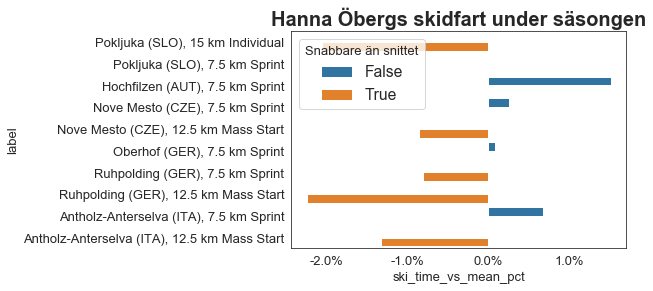

In [18]:
# Hanna Öbergs skidtider
df_hanna = df[df["name"] == "H. OEBERG"].sort_values("date")
df_hanna[u"Snabbare än snittet"] = df_hanna["ski_time_vs_mean_pct"] < 0
df_hanna["label"] = df_hanna["race_key"].str.replace("2018-2019, ","").str.replace("Women ","")

ax = sns.barplot(data=df_hanna, y="label", x="ski_time_vs_mean_pct", hue=u"Snabbare än snittet", orient="h")
ax.set_title(u"Hanna Öbergs skidfart under säsongen")
ax.set_xticklabels(['{:,.1%}'.format(x) for x in ax.get_xticks()])
plt.show()


## Who are the fastest shooters?

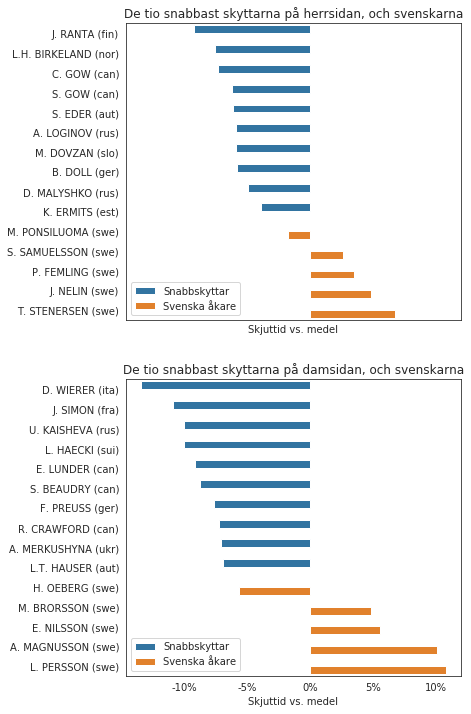

Table url: https://www.dropbox.com/s/e6yw0wtposgc96i/snabbaste+skyttarna.xlsx?dl=0


Rank  \
sex   runner                       
men   J. RANTA (fin)         1.0   
      L.H. BIRKELAND (nor)   2.0   
      C. GOW (can)           3.0   
      S. GOW (can)           4.0   
      S. EDER (aut)          5.0   
      A. LOGINOV (rus)       6.0   
      M. DOVZAN (slo)        7.0   
      B. DOLL (ger)          8.0   
      D. MALYSHKO (rus)      9.0   
      K. ERMITS (est)       10.0   
      M. PONSILUOMA (swe)   22.0   
      S. SAMUELSSON (swe)   52.0   
      P. FEMLING (swe)      56.0   
      J. NELIN (swe)        68.0   
      T. STENERSEN (swe)    77.0   
women D. WIERER (ita)        1.0   
      J. SIMON (fra)         2.0   
      U. KAISHEVA (rus)      3.0   
      L. HAECKI (sui)        4.0   
      E. LUNDER (can)        5.0   
      S. BEAUDRY (can)       6.0   
      F. PREUSS (ger)        7.0   
      R. CRAWFORD (can)      8.0   
      A. MERKUSHYNA (ukr)    9.0   
      L.T. HAUSER (aut)     10.0   
      H. OEBERG (swe)       12.0   
      M. BRORSSON (swe)     63.0   
      E. NILSSON (swe)      67.0   
      A. MAGNUSSON (swe)    87.0   
      L. PERSSON (swe)      90.0   

                            Procent snabbare/långsammare än topp-30-snitt  \
sex   runner                                                                
men   J. RANTA (fin)                                                 -9.2   
      L.H. BIRKELAND (nor)                                           -7.5   
      C. GOW (can)                                                   -7.3   
      S. GOW (can)                                                   -6.2   
      S. EDER (aut)                                                  -6.1   
      A. LOGINOV (rus)                                               -5.9   
      M. DOVZAN (slo)                                                -5.9   
      B. DOLL (ger)                                                  -5.8   
      D. MALYSHKO (rus)                                              -4.9   
      K. ERMITS (est)                                                -3.9   
      M. PONSILUOMA (swe)                                            -1.7   
      S. SAMUELSSON (swe)                                             2.6   
      P. FEMLING (swe)                                                3.5   
      J. NELIN (swe)                                                  4.9   
      T. STENERSEN (swe)                                              6.8   
women D. WIERER (ita)                                               -13.4   
      J. SIMON (fra)                                                -10.9   
      U. KAISHEVA (rus)                                             -10.0   
      L. HAECKI (sui)                                               -10.0   
      E. LUNDER (can)                                                -9.1   
      S. BEAUDRY (can)                                               -8.7   
      F. PREUSS (ger)                                                -7.6   
      R. CRAWFORD (can)                                              -7.2   
      A. MERKUSHYNA (ukr)                                            -7.1   
      L.T. HAUSER (aut)                                              -6.9   
      H. OEBERG (swe)                                                -5.6   
      M. BRORSSON (swe)                                               4.9   
      E. NILSSON (swe)                                                5.6   
      A. MAGNUSSON (swe)                                             10.1   
      L. PERSSON (swe)                                               10.8   

                            Antal lopp  
sex   runner                            
men   J. RANTA (fin)                 5  
      L.H. BIRKELAND (nor)           7  
      C. GOW (can)                  10  
      S. GOW (can)                   7  
      S. EDER (aut)                 11  
      A. LOGINOV (rus)              11  
      M. DOVZAN (slo)                8  
      B. DOLL (ger)                 11  


In [107]:
by_runner = df.groupby(["sex", "runner"])
df_viz = pd.concat([
  by_runner["range_time_vs_mean_pct"].mean().rename("range_time_vs_mean") * 100,
  by_runner["range_time_vs_mean_pct"].count().rename("n_races"),
  by_runner["nat"].first(),
    
], axis=1)\
.sort_values(["sex" ,"range_time_vs_mean"])

# only include runners with at lest five races
df_viz = df_viz[df_viz["n_races"] >= 5]

df_viz["rank"] = df_viz.groupby("sex")["range_time_vs_mean"].rank()

# select top 10 + swedes
df_viz = df_viz[(df_viz["rank"] <= 10) | (df_viz["nat"] == "swe")].round(1)


df_viz.loc[df_viz["rank"] <= 10, "cat"] = u"Snabbskyttar"
df_viz.loc[df_viz["nat"] == "swe", "cat"] = u"Svenska åkare"

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(6,12), sharex=True)

for i, sex in enumerate(["men", "women"]):
    ax = axes[i]
    sns.barplot(x="range_time_vs_mean", y="runner", data=df_viz.loc[sex].reset_index(), hue="cat", ax=ax)
    ax.legend(title=None)
    title = u"De tio snabbast skyttarna på"
    if sex == "men":
        title += " herrsidan"
    elif sex == "women":
        title += " damsidan"
    title += ", och svenskarna"
    ax.set(xlabel='Skjuttid vs. medel', ylabel="", title=title)
    ax.set_xticklabels(['{:,.0%}'.format(x / 100) for x in ax.get_xticks()])

plt.show()

export_df = df_viz[["rank", "range_time_vs_mean","n_races", ]].rename(columns={"range_time_vs_mean": "Procent snabbare/långsammare än topp-30-snitt",
                                                              "rank": "Rank", "n_races": "Antal lopp"})
save_table(u"snabbaste skyttarna", export_df)
export_df

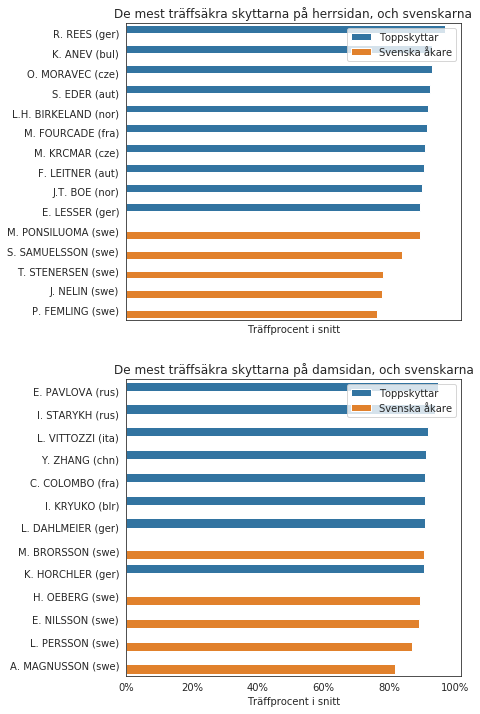

Table url: https://www.dropbox.com/s/e6yw0wtposgc96i/b%C3%A4sta+skyttarna.xlsx?dl=0


Rank  Träffprocent  Antal lopp
sex   runner                                              
women E. PAVLOVA (rus)       1.0          95.0           6
      I. STARYKH (rus)       2.0          93.9           9
      L. VITTOZZI (ita)      3.0          91.7          12
      Y. ZHANG (chn)         4.0          91.2           8
      C. COLOMBO (fra)       5.0          91.0           5
      I. KRYUKO (blr)        6.0          91.0          10
      L. DAHLMEIER (ger)     7.0          90.8           6
      M. BRORSSON (swe)      8.0          90.5          10
      K. HORCHLER (ger)      9.0          90.5          11
      H. OEBERG (swe)       13.5          89.4           9
      E. NILSSON (swe)      15.0          89.2           6
      L. PERSSON (swe)      34.5          86.9           8
      A. MAGNUSSON (swe)    63.0          81.7           6
men   R. REES (ger)          1.0          97.0           5
      K. ANEV (bul)          2.0          93.1           8
      O. MORAVEC (cze)       3.0          93.0          10
      S. EDER (aut)          4.0          92.5          12
      L.H. BIRKELAND (nor)   5.0          91.9           8
      M. FOURCADE (fra)      6.0          91.5          10
      M. KRCMAR (cze)        7.0          90.8          12
      F. LEITNER (aut)       8.0          90.6           9
      J.T. BOE (nor)         9.0          90.0          12
      E. LESSER (ger)       10.0          89.3           7
      M. PONSILUOMA (swe)   11.0          89.3           7
      S. SAMUELSSON (swe)   48.5          83.9           9
      T. STENERSEN (swe)    75.0          78.3           6
      J. NELIN (swe)        78.0          77.9           7
      P. FEMLING (swe)      82.5          76.2           8

In [103]:
by_runner = df.groupby(["sex", "runner"])
df_viz = pd.concat([
  by_runner["shot_pct"].mean().rename("shot_pct") * 100,
  by_runner["shot_pct"].count().rename("n_races"),
  by_runner["nat"].first(),
    
], axis=1)\
.sort_values(["sex" ,"shot_pct"], ascending=False)

# only include runners with at lest five races
df_viz = df_viz[df_viz["n_races"] >= 5]

df_viz["rank"] = df_viz.groupby("sex")["shot_pct"].rank(ascending=False)

# select top 10 + swedes
df_viz = df_viz[(df_viz["rank"] <= 10) | (df_viz["nat"] == "swe")].round(1)


df_viz.loc[df_viz["rank"] <= 10, "cat"] = u"Toppskyttar"
df_viz.loc[df_viz["nat"] == "swe", "cat"] = u"Svenska åkare"

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(6,12), sharex=True)

for i, sex in enumerate(["men", "women"]):
    ax = axes[i]
    sns.barplot(x="shot_pct", y="runner", data=df_viz.loc[sex].reset_index(), hue="cat", ax=ax)
    ax.legend(title=None)
    title = u"De mest träffsäkra skyttarna på"
    if sex == "men":
        title += " herrsidan"
    elif sex == "women":
        title += " damsidan"
    title += ", och svenskarna"
    ax.set(xlabel=u'Träffprocent i snitt', ylabel="", title=title)
    ax.set_xticklabels(['{:,.0%}'.format(x / 100) for x in ax.get_xticks()])

plt.show()

export_df = df_viz[["rank", "shot_pct","n_races", ]].rename(columns={"shot_pct": u"Träffprocent",
                                                              "rank": "Rank", "n_races": "Antal lopp"})
save_table(u"bästa skyttarna", export_df)
export_df

## Fastest skiers + shooters

In [46]:
by_runner = df.groupby(["sex", "runner"])
df_skiers = pd.concat([
  by_runner["ski_and_range_time_vs_mean_pct"].mean().rename("ski_and_range_time_vs_mean") * 100,
  by_runner["ski_and_range_time_vs_mean_pct"].count().rename("n_races"),
  by_runner["nat"].first(),
    
], axis=1)\
.sort_values(["sex" ,"ski_and_range_time_vs_mean"])

# only include runners with at lest five races
df_skiers = df_skiers[df_skiers["n_races"] >= 5]

df_skiers["rank"] = df_skiers.groupby("sex")["ski_and_range_time_vs_mean"].rank()

# Vilka löpare är bättre än HAnna Öberg
hanna_rank = df_skiers.loc[("women", "H. OEBERG (swe)")]["rank"]
print "Hanna Öberg rank :", hanna_rank
print "Faster skiers (and shooters): "
df_skiers[df_skiers["rank"] < hanna_rank].loc["women"].index


Hanna Öberg rank : 9.0
Faster skiers (and shooters): 


Index([u'A. KUZMINA (svk)', u'M.O. ROEISELAND (nor)', u'K. MAKARAINEN (fin)',
       u'D. HERRMANN (ger)', u'D. WIERER (ita)', u'T. ECKHOFF (nor)',
       u'P. FIALKOVA (svk)', u'L. VITTOZZI (ita)'],
      dtype='object', name=u'runner')

In [48]:
# Vilka löpare är bättre än Sebastian Samuelsson?
# Vilka löpare är bättre än HAnna Öberg
seb_rank = df_skiers.loc[("men", "S. SAMUELSSON (swe)")]["rank"]
print "Sebastian Samuelssons rank :", seb_rank
print "Faster skiers (and shooters): "
df_skiers[df_skiers["rank"] < seb_rank].loc["men"].index



Sebastian Samuelssons rank : 22.0
Faster skiers (and shooters): 


Index([u'J.T. BOE (nor)', u'S. DESTHIEUX (fra)', u'J. EBERHARD (aut)',
       u'B. DOLL (ger)', u'A. LOGINOV (rus)', u'M. FOURCADE (fra)',
       u'T. BOE (nor)', u'L. HOFER (ita)', u'A. PEIFFER (ger)',
       u'Q. FILLON MAILLET (fra)', u'A. GUIGONNAT (fra)',
       u'E. BJOENTEGAARD (nor)', u'L'ABEE-LUND HENRIK (nor)',
       u'B. WEGER (sui)', u'J. KUEHN (ger)', u'S. EDER (aut)', u'J. FAK (slo)',
       u'D. WINDISCH (ita)', u'V.S. CHRISTIANSEN (nor)',
       u'E. GARANICHEV (rus)', u'A. RASTORGUJEVS (lat)'],
      dtype='object', name=u'runner')

## Correlation between strengths and result

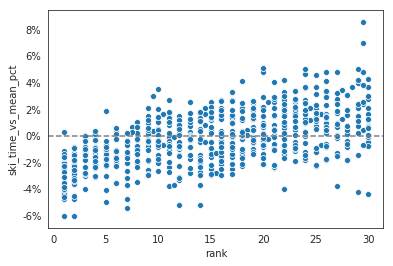

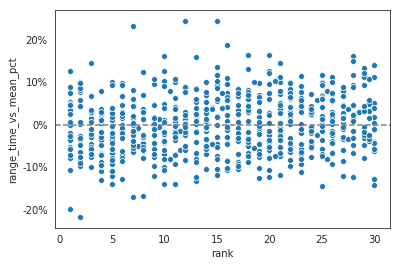

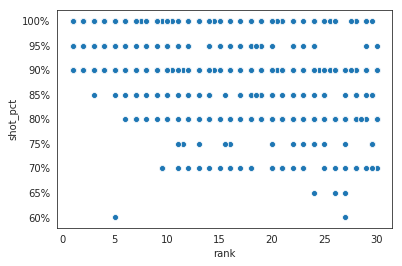

In [143]:
for measure in ["ski_time", "range_time", "misses"]:
    if measure == "misses":
        y = "shot_pct"
    else: 
        y = "{}_vs_mean_pct".format(measure)
    x = "rank"
    df_viz = df[df.is_top_30]
    ax = sns.scatterplot(x=x, y=y, data=df_viz)
    #ax.set_xticklabels(['{:,.0%}'.format(x) for x in ax.get_xticks()])
    ax.set_yticklabels(['{:,.0%}'.format(x) for x in ax.get_yticks()])
    if measure != "misses":
        ax.axhline(0, c="gray", linestyle="dashed")
    plt.show()

## Relative strengths and weaknesses of top runners

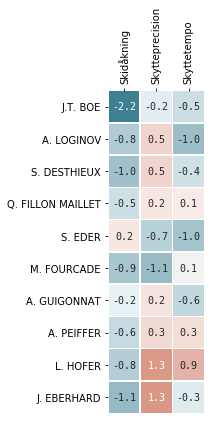

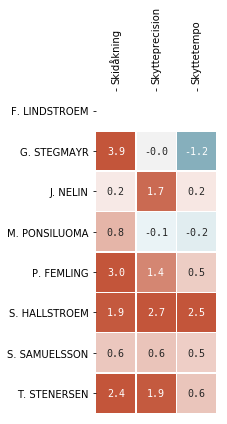

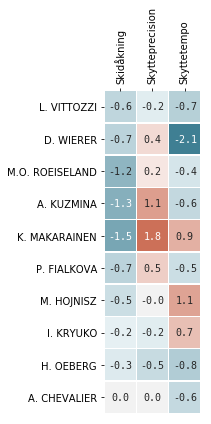

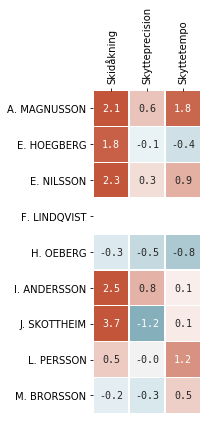

In [78]:
TOP_RUNNERS = {
    "women": ["L. VITTOZZI",
    "D. WIERER",
    "M.O. ROEISELAND",
    "A. KUZMINA",
    "K. MAKARAINEN",
    "P. FIALKOVA",
    "M. HOJNISZ",
    "I. KRYUKO",
    "H. OEBERG",
    "A. CHEVALIER",
    ],
    "men": [
    "J.T. BOE",
    "A. LOGINOV",
    "S. DESTHIEUX",
    "Q. FILLON MAILLET",
    "S. EDER",
    "M. FOURCADE",
    "A. GUIGONNAT",
    "A. PEIFFER",
    "L. HOFER",
    "J. EBERHARD",
    ]
}

def plot_strengths(df, order=None):
    table_df = df.groupby("name")[["ski_time_vs_mean_std", "range_time_vs_mean_std", "misses_vs_mean_std", "median_rank", "ski_time_vs_mean_pct"]].median().reset_index()
    if order:
        table_df["name"] = table_df["name"].astype("category")
        table_df["name"] = table_df["name"].cat.set_categories(order)
        table_df = table_df.sort_values("name")
    table_df = table_df.set_index("name")
    plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
    plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True

    f, ax = plt.subplots(figsize=(8, 6))

    # Generate a custom diverging colormap
    #cmap = sns.diverging_palette(2, -2, as_cmap=True)
    cmap = sns.diverging_palette(220, 20, n=7, as_cmap=True)
    sns.color_palette("RdBu_r", 7)

    # Draw the heatmap with the mask and correct aspect ratio
    ax = sns.heatmap(table_df[["ski_time_vs_mean_std", "misses_vs_mean_std", "range_time_vs_mean_std"]], 
                cmap=cmap, cbar=False, vmax=2, center=0, square=True, linewidths=.5, annot=True, fmt=".1f", 
                annot_kws={"fontname": "Monospace"})
    title = u"Toppåkarnas relativa styrkor"
    ax.set(ylabel="")
    translate = {
        "ski_time_vs_mean_std": u"Skidåkning",
        "range_time_vs_mean_std": u"Skyttetempo",
        "misses_vs_mean_std": u"Skytteprecision",
    }
    ax.set_xticklabels([translate[x.get_text()] for x in ax.get_xticklabels()])
    f.tight_layout()
    
    plt.show()

for sex, top_runners in TOP_RUNNERS.items():
    top_runnders_df = df[df["name"].isin(top_runners)]
        
    plot_strengths(top_runnders_df, order=top_runners)
    
    df_swe = df[(df["sex"] == sex) & (df["nat"] == "swe")]
    plot_strengths(df_swe)

## Result simulation

In [122]:
def make_race_simulations(df, race, n_race_threshold=5, n_simulations=10000):
    assert race in df.race.unique(), df.race.unique()

    sex = race.split(" ")[0].lower()

    def get_discipline(race):
        return race.split("km ")[-1].replace("Short Individual", "Individual")

    discipline = get_discipline(race)
    if discipline == "Sprint":
        n_shootings = 2
    else:
        n_shootings = 4

    by_runner = df[(df["sex"] == sex) & df["misses"].notna()].groupby("runner")
    _df = pd.concat([
       (1 - (by_runner["misses"].sum() / by_runner["n_shots"].sum() )).rename("shot_pct"),
       by_runner["ski_time_vs_mean_pct"].mean().rename("ski_time_mean"), 
       by_runner["ski_time_vs_mean_pct"].std().rename("ski_time_std"), 
       by_runner.apply(lambda x: (x["range_time"].dt.seconds / x["n_shootings"]).mean()).rename("range_time_mean"), 
       by_runner.apply(lambda x: (x["range_time"].dt.seconds / x["n_shootings"]).std()).rename("range_time_std"), 

        by_runner["name"].count().rename("n_races"),
       df[df["discipline"] != "Individual"].groupby("runner")["avg_penalty_time"].mean().sort_values() 
    ], axis=1)
    _df = _df[_df["n_races"] >= n_race_threshold]

    # Get the average race time
    race_times = df[df.is_top_30].groupby("race")["final_time_abs"].apply(lambda x: x.dt.seconds.mean())
    race_time = race_times.loc[race]


    print "Expected race time: {}".format(race_time / 60)


    def simulate_ski_time(row):
        vs_mean = np.random.normal(row["ski_time_mean"], row["ski_time_std"], n_simulations) + 1
        return vs_mean * race_time

    def simulate_range_time(row):
        return np.random.normal(row["range_time_mean"], row["range_time_std"], n_simulations) * n_shootings

    def simulate_penalty_time(row):
        n_hits = np.random.binomial(n_shootings * 5, row["shot_pct"], n_simulations)
        n_misses = n_shootings * 5 - n_hits
        if "Individual" in race:
            penalty_time = 60
        else:
            penalty_time = row["avg_penalty_time"]
        return n_misses * penalty_time

    ski_time_sims = _df.apply(simulate_ski_time, axis=1)
    range_time_sims = _df.apply(simulate_range_time, axis=1)
    penalty_time_sims = _df.apply(simulate_penalty_time, axis=1)
    total_time_sims = ski_time_sims + range_time_sims + penalty_time_sims

    simulations = pd.DataFrame(np.stack(total_time_sims, axis=0), index=_df.index)
    return simulations


def get_ranks(simulations):
    simulations_ranks = simulations.rank()
    n_simulations = simulations.shape[1]

    prob_podium = simulations_ranks[simulations_ranks<=3].count(axis=1) / float(n_simulations)
    prob_win = simulations_ranks[simulations_ranks==1].count(axis=1) / float(n_simulations)
        
    return pd.concat([
      prob_win.rename("prob_win"),
      prob_podium.rename("prob_podium"),
    ], axis=1)

rank_dfs = []
for race in ["Women 7.5 km Sprint", "Women 12.5 km Mass Start", "Women 15 km Individual"]:
#for race in ["Men 10 km Sprint", "Men 15 km Mass Start", "Men 20 km Individual"]:
    sims = make_race_simulations(df, race)
    _ranks_df = get_ranks(sims).sort_values("prob_win",ascending=False)
    _ranks_df["race"] = race
    rank_dfs.append(_ranks_df)
    
rank_df = pd.concat(rank_dfs)
rank_df

/home/jens/.local/lib/python2.7/site-packages/ipykernel_launcher.py:25: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Expected race time: 21.4807692308
Expected race time: 35.8875968992
Expected race time: 44.3077777778


prob_win  prob_podium                    race
L. VITTOZZI (ita)        0.1230       0.2474     Women 7.5 km Sprint
M.O. ROEISELAND (nor)    0.1090       0.2665     Women 7.5 km Sprint
A. KUZMINA (svk)         0.0934       0.2576     Women 7.5 km Sprint
D. WIERER (ita)          0.0767       0.2445     Women 7.5 km Sprint
K. MAKARAINEN (fin)      0.0599       0.1547     Women 7.5 km Sprint
L. DAHLMEIER (ger)       0.0550       0.1518     Women 7.5 km Sprint
A. CHEVALIER (fra)       0.0518       0.1198     Women 7.5 km Sprint
P. FIALKOVA (svk)        0.0499       0.1797     Women 7.5 km Sprint
D. HERRMANN (ger)        0.0472       0.1209     Women 7.5 km Sprint
H. OEBERG (swe)          0.0322       0.1229     Women 7.5 km Sprint
T. ECKHOFF (nor)         0.0274       0.0880     Women 7.5 km Sprint
V. VITKOVA (cze)         0.0267       0.0520     Women 7.5 km Sprint
O. PIDHRUSHNA (ukr)      0.0258       0.0584     Women 7.5 km Sprint
M. HOJNISZ (pol)         0.0219       0.0806     Women 7.5 km Sprint
E. PAVLOVA (rus)         0.0213       0.0507     Women 7.5 km Sprint
A. BESCOND (fra)         0.0170       0.0614     Women 7.5 km Sprint
I. KRYUKO (blr)          0.0156       0.0814     Women 7.5 km Sprint
F. HILDEBRAND (ger)      0.0155       0.0545     Women 7.5 km Sprint
I.L. TANDREVOLD (nor)    0.0153       0.0666     Women 7.5 km Sprint
M. BRORSSON (swe)        0.0128       0.0523     Women 7.5 km Sprint
F. PREUSS (ger)          0.0124       0.0570     Women 7.5 km Sprint
A. MAGNUSSON (swe)       0.0111       0.0211     Women 7.5 km Sprint
J. SIMON (fra)           0.0100       0.0551     Women 7.5 km Sprint
M. DAVIDOVA (cze)        0.0085       0.0423     Women 7.5 km Sprint
J. BRAISAZ (fra)         0.0070       0.0282     Women 7.5 km Sprint
S. MIRONOVA (rus)        0.0065       0.0440     Women 7.5 km Sprint
C. AYMONIER (fra)        0.0065       0.0307     Women 7.5 km Sprint
L. HAECKI (sui)          0.0060       0.0291     Women 7.5 km Sprint
V. HINZ (ger)            0.0059       0.0317     Women 7.5 km Sprint
I. STARYKH (rus)         0.0058       0.0253     Women 7.5 km Sprint
...                         ...          ...                     ...
S. MAEDA (jpn)           0.0000       0.0001  Women 15 km Individual
V. LEHTONEN (fin)        0.0000       0.0000  Women 15 km Individual
G. GAIM (est)            0.0000       0.0000  Women 15 km Individual
A. GASPARIN (sui)        0.0000       0.0000  Women 15 km Individual
Y. BELCHENKO (kaz)       0.0000       0.0001  Women 15 km Individual
G. LESCINSKAITE (ltu)    0.0000       0.0000  Women 15 km Individual
Y. TANAKA (jpn)          0.0000       0.0000  Women 15 km Individual
Y. ZHANG (chn)           0.0000       0.0000  Women 15 km Individual
S. MEINEN (sui)          0.0000       0.0000  Women 15 km Individual
J. TALIHAERM (est)       0.0000       0.0004  Women 15 km Individual
L. AKHATOVA (kaz)        0.0000       0.0000  Women 15 km Individual
J. TANG (chn)            0.0000       0.0000  Women 15 km Individual
L. EINFALT (slo)         0.0000       0.0000  Women 15 km Individual
E. LUNDER (can)          0.0000       0.0001  Women 15 km Individual
E. KO (kor)              0.0000       0.0000  Women 15 km Individual
L. TOIVANEN (fin)        0.0000       0.0000  Women 15 km Individual
D. YURKEVICH (blr)       0.0000       0.0000  Women 15 km Individual
M. BANKES (can)          0.0000       0.0000  Women 15 km Individual
D. STOYANOVA (bul)       0.0000       0.0001  Women 15 km Individual
D. KADEVA (bul)          0.0000       0.0000  Women 15 km Individual
D. ALIMBEKAVA (blr)      0.0000       0.0015  Women 15 km Individual
I. FIALKOVA (svk)        0.0000       0.0008  Women 15 km Individual
C. RIEDER (aut)          0.0000       0.0000  Women 15 km Individual
K. PITON (pol)           0.0000       0.0000  Women 15 km Individual
N. KOCERGINA (ltu)       0.0000       0.0000  Women 15 km Individual
E. YORDANOVA (bul)       0.0000       0.0000  Women 15 km Individual
P. KLEMENCIC (slo)   

In [123]:
col_translations = {"prob_win": "Vinstchans", "prob_podium": "Medaljchans"}
for race, race_ranks in rank_df.sort_values("prob_win", ascending=False).groupby("race"):
    print "\n" + race
    print race_ranks[["prob_win", "prob_podium"]].head(10).multiply(100).round(1).rename(columns=col_translations)
    print "\n\nSvenskarna"
    is_swe = race_ranks.index.str.endswith("swe)")
    print race_ranks.loc[is_swe, ["prob_win", "prob_podium"]].multiply(100).round(1).rename(columns=col_translations)



Women 12.5 km Mass Start
                       Vinstchans  Medaljchans
L. VITTOZZI (ita)            15.2         29.4
M.O. ROEISELAND (nor)        10.1         27.1
A. KUZMINA (svk)              9.0         25.9
D. WIERER (ita)               9.0         28.0
A. CHEVALIER (fra)            5.6         12.8
L. DAHLMEIER (ger)            5.5         15.6
P. FIALKOVA (svk)             5.5         19.6
H. OEBERG (swe)               4.3         14.6
K. MAKARAINEN (fin)           3.6         10.6
O. PIDHRUSHNA (ukr)           3.0          6.5


Svenskarna
                    Vinstchans  Medaljchans
H. OEBERG (swe)            4.3         14.6
M. BRORSSON (swe)          1.4          5.7
A. MAGNUSSON (swe)         1.0          2.0
L. PERSSON (swe)           0.1          0.8
E. NILSSON (swe)           0.0          0.3

Women 15 km Individual
                       Vinstchans  Medaljchans
L. VITTOZZI (ita)            14.2         29.2
D. WIERER (ita)               8.4         21.7
M.O. ROEISELAND

In [99]:

print rank_df.loc["H. OEBERG (swe)"].set_index("race")[["prob_win", "prob_podium"]].multiply(100).round(1).rename(columns=col_translations)


                          Vinstchans  Medaljchans
race                                             
Women 7.5 km Sprint              3.1         11.8
Women 12.5 km Mass Start         4.3         15.2
Women 15 km Individual           4.9         15.9


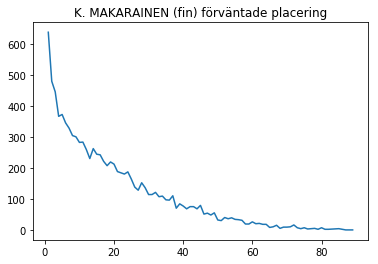

In [118]:
runner = "K. MAKARAINEN (fin)"
s = simulations.rank().loc[runner]
s.value_counts().sort_index().plot(title=u"{} förväntade placering".format(runner))


In [119]:
s[s==1].count()

638

In [54]:
rank_df.sort_values(["race", "prob_win"], ascending=False).groupby("race").head(10)

prob_win  prob_podium                      race
L. VITTOZZI (ita)        0.1210       0.2402       Women 7.5 km Sprint
M.O. ROEISELAND (nor)    0.1014       0.2686       Women 7.5 km Sprint
A. KUZMINA (svk)         0.0998       0.2702       Women 7.5 km Sprint
D. WIERER (ita)          0.0790       0.2375       Women 7.5 km Sprint
K. MAKARAINEN (fin)      0.0605       0.1519       Women 7.5 km Sprint
L. DAHLMEIER (ger)       0.0519       0.1436       Women 7.5 km Sprint
A. CHEVALIER (fra)       0.0491       0.1130       Women 7.5 km Sprint
P. FIALKOVA (svk)        0.0479       0.1776       Women 7.5 km Sprint
D. HERRMANN (ger)        0.0408       0.1135       Women 7.5 km Sprint
H. OEBERG (swe)          0.0349       0.1353       Women 7.5 km Sprint
L. VITTOZZI (ita)        0.1433       0.2868    Women 15 km Individual
D. WIERER (ita)          0.0802       0.2197    Women 15 km Individual
M.O. ROEISELAND (nor)    0.0694       0.1807    Women 15 km Individual
L. DAHLMEIER (ger)       0.0641       0.1721    Women 15 km Individual
H. OEBERG (swe)          0.0559       0.1693    Women 15 km Individual
P. FIALKOVA (svk)        0.0532       0.1601    Women 15 km Individual
A. KUZMINA (svk)         0.0487       0.1361    Women 15 km Individual
A. CHEVALIER (fra)       0.0446       0.1146    Women 15 km Individual
I. KRYUKO (blr)          0.0389       0.1399    Women 15 km Individual
E. PAVLOVA (rus)         0.0379       0.1014    Women 15 km Individual
L. VITTOZZI (ita)        0.1494       0.2935  Women 12.5 km Mass Start
M.O. ROEISELAND (nor)    0.1029       0.2670  Women 12.5 km Mass Start
D. WIERER (ita)          0.0962       0.2789  Women 12.5 km Mass Start
A. KUZMINA (svk)         0.0819       0.2448  Women 12.5 km Mass Start
A. CHEVALIER (fra)       0.0531       0.1273  Women 12.5 km Mass Start
L. DAHLMEIER (ger)       0.0519       0.1483  Women 12.5 km Mass Start
P. FIALKOVA (svk)        0.0492       0.1866  Women 12.5 km Mass Start
H. OEBERG (swe)          0.0468       0.1557  Women 12.5 km Mass Start
K. MAKARAINEN (fin)      0.0366       0.1106  Women 12.5 km Mass Start
V. VITKOVA (cze)         0.0290       0.0562  Women 12.5 km Mass Start

discipline
Individual    2562.358333
Mass Start    2211.835294
Sprint        1396.473684
Name: final_time_abs, dtype: float64

In [307]:
df.columns

Index([                        u'season',                          u'event',
                                 u'race',                            u'sex',
                                 u'name',                            u'nat',
                             u'ski_time',                     u'range_time',
                               u'misses',                 u'final_time_abs',
                                 u'date',                         u'runner',
                             u'race_key',                     u'discipline',
                          u'n_shootings',                        u'n_shots',
                             u'shot_pct',                   u'penalty_time',
                   u'ski_and_range_time',               u'avg_penalty_time',
           u'final_time_without_penalty',                           u'rank',
                            u'is_top_30',                      u'is_top_10',
                             u'is_top_5',                       u'is_top_3',

(array([  7.,  54., 118., 210., 212., 200., 108.,  56.,  24.,  11.]),
 array([2359.42118306, 2426.85741475, 2494.29364643, 2561.72987812,
        2629.16610981, 2696.60234149, 2764.03857318, 2831.47480487,
        2898.91103655, 2966.34726824, 3033.78349993]),
 <a list of 10 Patch objects>)

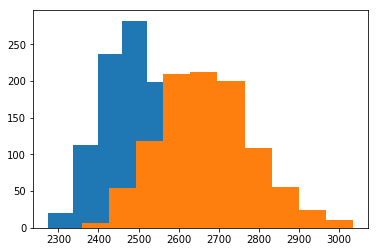

In [294]:
plt.hist(analysis_df.loc["H. OEBERG (swe)"]["total_time_sims"])
plt.hist(analysis_df.loc["V. SEMERENKO (ukr)"]["total_time_sims"])


In [296]:
df[df.name == "V. SEMERENKO"][std_cols]

ski_time_vs_mean_std  range_time_vs_mean_std  penalty_time_vs_mean_std  \
60                1.863336               -0.570313                  0.568750   
167               1.007667                1.402523                 -0.796061   
371               2.112330                0.241294                 -0.268891   
372               2.112330                0.241294                  2.119861   
373               2.112330                0.241294                 -0.268891   
374               2.112330                0.241294                  2.119861   
375               2.112330                0.491524                 -0.393956   
376               2.112330                0.491524                  1.994795   
377               2.112330                0.491524                 -0.393956   
378               2.112330                0.491524                  1.994795   
379               1.335935                0.241294                  0.637834   
380               1.335935                0.241294                  3.026586   
381               1.335935                0.241294                  0.637834   
382               1.335935                0.241294                  3.026586   
383               1.335935                0.491524                  0.512769   
384               1.335935                0.491524                  2.901520   
385               1.335935                0.491524                  0.512769   
386               1.335935                0.491524                  2.901520   
518               0.210577               -0.140663                 -0.506622   
519               0.210577               -0.140663                  3.907595   
520               0.210577               -0.140663                 -0.506622   
521               0.210577               -0.140663                  3.907595   
522               0.210577                0.279417                 -0.589695   
523               0.210577                0.279417                  3.824521   
524               0.210577                0.279417                 -0.589695   
525               0.210577                0.279417                  3.824521   
526               1.774685               -0.140663                 -1.767826   
527               1.774685               -0.140663                  2.646390   
528               1.774685               -0.140663                 -1.767826   
529               1.774685               -0.140663                  2.646390   
...                    ...                     ...                       ...   
877               0.761763                0.546280                 -0.003154   
878               0.761763                0.546280                  2.663941   
883               0.761763               -0.641389                  0.409403   
884               0.761763               -0.641389                  3.076498   
886               0.761763               -0.641389                  0.409403   
887               0.761763               -0.641389                  3.076498   
892               1.544305                0.546280                 -1.359945   
893               1.544305                0.546280                  1.307151   
895               1.544305                0.546280                 -1.359945   
896               1.544305                0.546280                  1.307151   
901               1.544305               -0.641389                 -0.947387   
902               1.544305               -0.641389                  1.719708   
904               1.544305               -0.641389                 -0.947387   
905               1.544305               -0.641389                  1.719708   
1067              1.837426                0.391943                  1.638982   
1068              1.837426                0.391943                  1.309660   
1069              1.837426                0.391943                  1.638982   
1070              1.837426                0.391943                  1.309660   
1071  

In [80]:

for col in ["ski_time"]: #, "range_time", "misses"]:
    print "\n\n******"
    print col
    print "\n\nNeeded to win"
    print df[df.is_winner].groupby(["sex","discipline"])[col + "_vs_mean_pct"].median() * 100

    print "\n\nNeeded for podium"
    print df[df.is_top_3].groupby(["sex","discipline"])[col + "_vs_mean_pct"].median() * 100

    



******
ski_time


Needed to win
sex    discipline
men    Individual   -3.798253
       Mass Start   -2.251213
       Sprint       -4.000738
women  Individual   -1.987363
       Mass Start   -1.654772
       Sprint       -2.697064
Name: ski_time_vs_mean_pct, dtype: float64


Needed for podium
sex    discipline
men    Individual   -2.196979
       Mass Start   -1.880425
       Sprint       -2.384945
women  Individual   -2.207399
       Mass Start   -2.276946
       Sprint       -2.697064
Name: ski_time_vs_mean_pct, dtype: float64


In [132]:
df[df.is_top_3].groupby(["sex", "event", "race"])["ski_time_vs_mean_pct"].max().sort_values()

sex    event                       race                          
women  Nove Mesto (CZE)            Women 12.5 km Mass Start         -0.028776
men    Canmore (CAN)               Men 15 km Short Individual       -0.028253
women  Soldier Hollow, Utah (USA)  Women 7.5 km Sprint              -0.028087
       Antholz-Anterselva (ITA)    Women 7.5 km Sprint              -0.020708
men    Ruhpolding (GER)            Men 15 km Mass Start             -0.015882
                                   Men 10 km Sprint                 -0.015729
       Oberhof (GER)               Men 10 km Sprint                 -0.014956
       Antholz-Anterselva (ITA)    Men 10 km Sprint                 -0.014453
                                   Men 15 km Mass Start             -0.014282
       Hochfilzen (AUT)            Men 10 km Sprint                 -0.014104
       Soldier Hollow, Utah (USA)  Men 10 km Sprint                 -0.013889
women  Pokljuka (SLO)              Women 7.5 km Sprint              -0.01302

In [237]:
df[df.race_key =="Women 15 km Individual"].sort_values("rank").head()

season           event                    race    sex         name  \
39  2018-2019  Pokljuka (SLO)  Women 15 km Individual  women    Y. DZHIMA   
28  2018-2019  Pokljuka (SLO)  Women 15 km Individual  women   M. HOJNISZ   
34  2018-2019  Pokljuka (SLO)  Women 15 km Individual  women  M. DAVIDOVA   
25  2018-2019  Pokljuka (SLO)  Women 15 km Individual  women  P. FIALKOVA   
64  2018-2019  Pokljuka (SLO)  Women 15 km Individual  women   B. BENDIKA   

    nat        ski_time      range_time  misses  final_time_abs  \
39  ukr 00:39:15.400000 00:00:40.300000     0.0 00:43:06.600000   
28  pol 00:38:15.700000 00:00:48.900000     1.0 00:43:12.500000   
34  cze 00:38:12.600000 00:01:02.300000     1.0 00:43:23.100000   
25  svk 00:37:56.700000 00:00:20.500000     2.0 00:43:26.100000   
64  lat 00:39:53.200000 00:00:25.400000     0.0 00:43:27.400000   

           ...                date         ski_time_vs_mean  \
39         ...          2018-12-06          00:00:05.923333   
28         ...          2018-12-06 -1 days +23:59:06.223333   
34         ...          2018-12-06 -1 days +23:59:03.123333   
25         ...          2018-12-06 -1 days +23:58:47.223333   
64         ...          2018-12-06          00:00:43.723333   

    ski_time_vs_mean_pct  ski_time_vs_mean_std       range_time_vs_mean  \
39              0.002521              0.117638          00:00:06.610000   
28             -0.022889             -1.068007          00:00:15.210000   
34             -0.024208             -1.129573          00:00:28.610000   
25             -0.030976             -1.445348 -1 days +23:59:46.810000   
64              0.018610              0.868347 -1 days +23:59:51.710000   

    range_time_vs_mean_pct  range_time_vs_mean_std  misses_vs_mean  \
39                0.196201                0.477791       -1.433333   
28                0.451469                1.099425       -0.433333   
34                0.849213                2.068019       -0.433333   
25               -0.391511               -0.953414        0.566667   
64               -0.246067               -0.599227       -1.433333   

    misses_vs_mean_pct  misses_vs_mean_std  
39           -1.000000           -1.378199  
28           -0.302326           -0.416665  
34           -0.302326           -0.416665  
25            0.395349            0.544869  
64           -1.000000           -1.378199  

[5 rows x 34 columns]

women


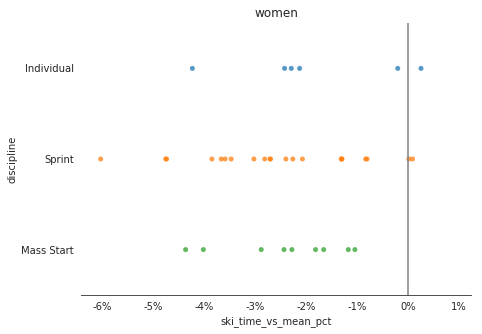

men


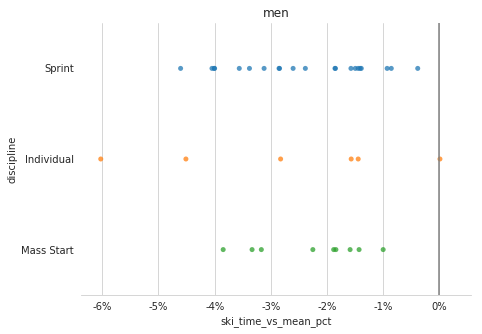

In [133]:
import seaborn as sns


for sex in df["sex"].unique():
    print sex
    f, ax = plt.subplots(figsize=(7,5))

    sns.set_style("whitegrid")
    sns.despine(left=True)

    # Show each observation with a scatterplot
    sns.stripplot(x="ski_time_vs_mean_pct", y="discipline",
                  data=df[(df.is_top_3) & (df["sex"] == sex)], dodge=True, jitter=False,
                  alpha=.75, zorder=1).set_title(sex)

    ax.set_xticklabels(['{:,.0%}'.format(x) for x in ax.get_xticks()])
    ax.axvline(x=0, color='grey', zorder=2)
    plt.show()

In [406]:
df[(df.discipline == "Sprint") & (df.ski_time_vs_mean_std < - 1.2)].groupby(["event", "race"]).name.count()

event                     race               
Antholz-Anterselva (ITA)  Women 7.5 km Sprint    4
Hochfilzen (AUT)          Women 7.5 km Sprint    4
Nove Mesto (CZE)          Women 7.5 km Sprint    8
Oberhof (GER)             Women 7.5 km Sprint    4
Pokljuka (SLO)            Women 7.5 km Sprint    1
Ruhpolding (GER)          Women 7.5 km Sprint    5
Name: name, dtype: int64

[Text(0,0,'-7%'),
 Text(0,0,'-6%'),
 Text(0,0,'-5%'),
 Text(0,0,'-4%'),
 Text(0,0,'-3%'),
 Text(0,0,'-2%'),
 Text(0,0,'-1%'),
 Text(0,0,'0%')]

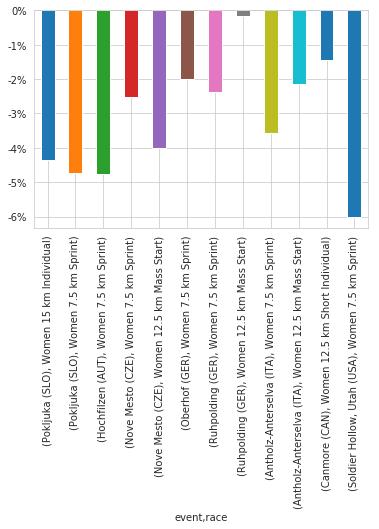

In [134]:
s = df[df.name == "K. MAKARAINEN"].sort_values("date").set_index(["event", "race"])["ski_time_vs_mean_pct"]
ax = s.plot.bar()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in ax.get_yticks()])

/home/jens/.local/lib/python2.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


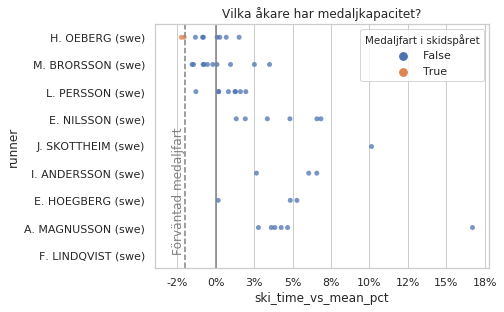

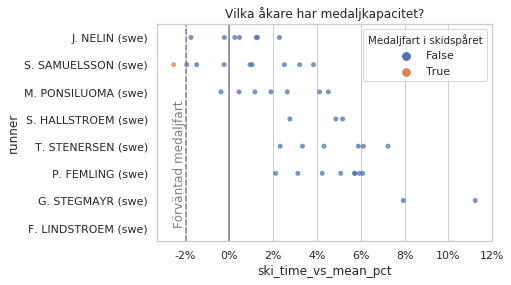

In [135]:

for sex in df["sex"].unique():
    TRHESHOLD = -0.02
    sns.set(style="whitegrid")

    col = "ski_time_vs_mean_pct"
    _df = df[(df.nat == "swe") & (df.sex == sex)]
    _df[u"Medaljfart i skidspåret"] = _df[col] < TRHESHOLD
    order = _df.groupby("runner")["median_ski_rank"].median().sort_values().index
    
    n_runners = _df.runner.nunique()

    # Initialize the figure with a logarithmic x axis
    f, ax = plt.subplots(figsize=(6, n_runners * 0.5))
    sns.set_style("whitegrid")

    # Plot the orbital period with horizontal boxes
    sns.stripplot(x=col, y="runner",
                  data=_df, dodge=False, jitter=False,
                  alpha=.75, zorder=1, order=order, hue=u"Medaljfart i skidspåret")

    ax.set_title(u"Vilka åkare har medaljkapacitet?")
    ax.set_xticklabels(['{:,.0%}'.format(x) for x in ax.get_xticks()])

    ax.axvline(x=TRHESHOLD, color='grey', zorder=2, linestyle="dashed")
    ax.axvline(x=0, color='grey', zorder=2)
    plt.text(TRHESHOLD, n_runners - 1 , u'Förväntad medaljfart',rotation=90, color="grey",
             ha="right", va="bottom")

In [380]:
df[df["name"] == "D. WIERER"][index_dims + ["ski_time_vs_mean_std"]]

season                     event                      race    sex  \
2     2018-2019            Pokljuka (SLO)    Women 15 km Individual  women   
117   2018-2019          Nove Mesto (CZE)       Women 10 km Pursuit  women   
206   2018-2019            Pokljuka (SLO)       Women 7.5 km Sprint  women   
315   2018-2019  Antholz-Anterselva (ITA)       Women 10 km Pursuit  women   
377   2018-2019          Ruhpolding (GER)  Women 12.5 km Mass Start  women   
449   2018-2019          Ruhpolding (GER)       Women 7.5 km Sprint  women   
589   2018-2019             Oberhof (GER)       Women 7.5 km Sprint  women   
674   2018-2019  Antholz-Anterselva (ITA)       Women 7.5 km Sprint  women   
810   2018-2019             Oberhof (GER)       Women 10 km Pursuit  women   
891   2018-2019          Nove Mesto (CZE)       Women 7.5 km Sprint  women   
976   2018-2019          Nove Mesto (CZE)  Women 12.5 km Mass Start  women   
1046  2018-2019          Hochfilzen (AUT)       Women 10 km Pursuit  women   
1160  2018-2019          Hochfilzen (AUT)       Women 7.5 km Sprint  women   
1254  2018-2019  Antholz-Anterselva (ITA)  Women 12.5 km Mass Start  women   
1294  2018-2019            Pokljuka (SLO)       Women 10 km Pursuit  women   

           name  nat  ski_time_vs_mean_std  
2     D. WIERER  ita             -0.766134  
117   D. WIERER  ita             -1.269192  
206   D. WIERER  ita             -0.714205  
315   D. WIERER  ita             -0.995143  
377   D. WIERER  ita             -0.141199  
449   D. WIERER  ita             -0.698756  
589   D. WIERER  ita              0.454091  
674   D. WIERER  ita             -0.608935  
810   D. WIERER  ita             -0.790365  
891   D. WIERER  ita             -1.299998  
976   D. WIERER  ita             -0.076076  
1046  D. WIERER  ita             -1.228937  
1160  D. WIERER  ita             -1.450535  
1254  D. WIERER  ita             -0.738296  
1294  D. WIERER  ita              1.217909

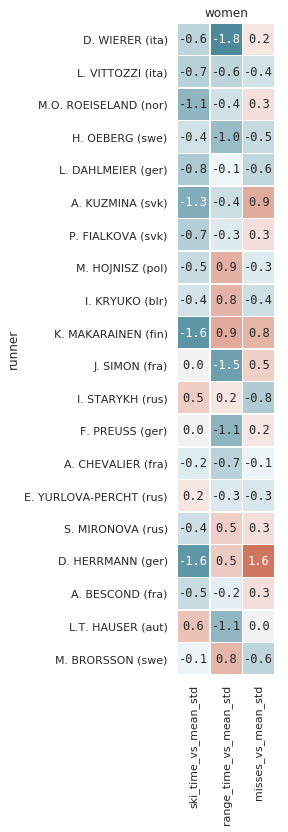

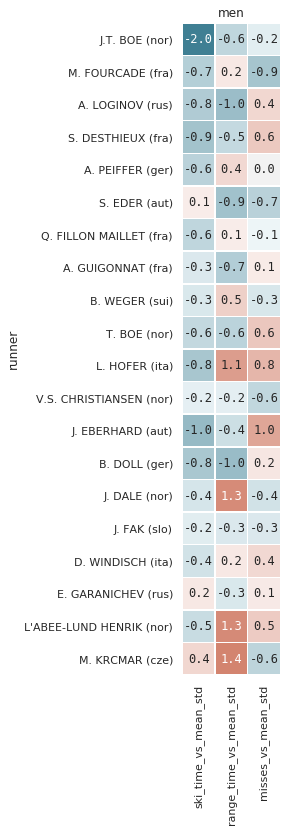

In [136]:
for sex in df["sex"].unique():
    table_df = df[df.is_top_30 & (df["sex"] == sex)].groupby("runner")[["ski_time_vs_mean_std", "range_time_vs_mean_std", "misses_vs_mean_std", "median_rank", "ski_time_vs_mean_pct"]].mean().sort_values("median_rank")

    f, ax = plt.subplots(figsize=(12, 12))

    # Generate a custom diverging colormap
    #cmap = sns.diverging_palette(2, -2, as_cmap=True)
    cmap = sns.diverging_palette(220, 20, n=7, as_cmap=True)
    sns.color_palette("RdBu_r", 7)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(table_df[["ski_time_vs_mean_std", "range_time_vs_mean_std", "misses_vs_mean_std"]].head(20), 
                cmap=cmap, cbar=False, vmax=2, center=0, square=True, linewidths=.5, annot=True, fmt=".1f", 
                annot_kws={"fontname": "Monospace"}).set_title(sex)


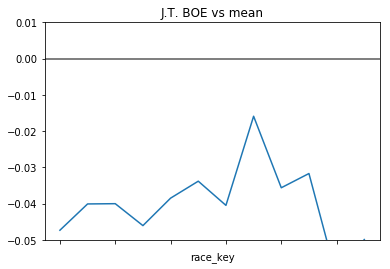

In [13]:
ax = df[df["runner"] == "J.T. BOE (nor)"].sort_values("date").set_index("race_key")["ski_time_vs_mean_pct"].plot()
ax.set_ylim([-0.05,0.01])
ax.set_title("J.T. BOE vs mean")
ax.axhline(0, c="grey", linewidth=2)


### Who could have won without penalites?

In [217]:
df[df.could_have_won].groupby("race_key").size()

race_key
2018-2019, Antholz-Anterselva (ITA), Men 10 km Sprint             7
2018-2019, Antholz-Anterselva (ITA), Men 15 km Mass Start         5
2018-2019, Antholz-Anterselva (ITA), Women 12.5 km Mass Start    16
2018-2019, Antholz-Anterselva (ITA), Women 7.5 km Sprint         13
2018-2019, Canmore (CAN), Women 12.5 km Short Individual          4
2018-2019, Hochfilzen (AUT), Men 10 km Sprint                     1
2018-2019, Hochfilzen (AUT), Women 7.5 km Sprint                  2
2018-2019, Nove Mesto (CZE), Men 10 km Sprint                     1
2018-2019, Nove Mesto (CZE), Men 15 km Mass Start                 4
2018-2019, Nove Mesto (CZE), Women 12.5 km Mass Start            18
2018-2019, Nove Mesto (CZE), Women 7.5 km Sprint                  6
2018-2019, Oberhof (GER), Women 7.5 km Sprint                     3
2018-2019, Pokljuka (SLO), Men 10 km Sprint                       2
2018-2019, Pokljuka (SLO), Men 20 km Individual                  15
2018-2019, Pokljuka (SLO), Women 15 km 

In [139]:
df[df.could_have_won & (df.nat == "nor")].groupby("name").size()

name
E. BJOENTEGAARD        6
I.L. TANDREVOLD        4
J. DALE                1
J.T. BOE              11
L'ABEE-LUND HENRIK     3
L.H. BIRKELAND         2
M.O. ROEISELAND       10
T. BOE                 5
T. ECKHOFF             4
V.S. CHRISTIANSEN      3
dtype: int64

In [211]:
df[(df.misses==0.0) & (df.discipline!="Sprint")]["penalty_time"].median() / 4

Timedelta('0 days 00:00:05.625000')

In [206]:
df.shape

(2101, 44)